### Импорты и настройка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.options.display.max_columns = 999
pd.set_option('display.precision', 2)
plt.style.use('ggplot')

In [3]:
df = pd.read_csv("../src/data.csv", index_col=0)

In [4]:
# Меняем названия русскоязычных столбцов
df.columns = ['ID', 'room_count', 'type', 'metro', 'address',
       'apartment_sqm', 'house_type', 'parking', 'price', 'tel', 'description',
       'furnish', 'rooms_sqm', 'balcony', 'windows', 'toilets',
       'kids_pets', 'extra', 'house_name',
       'house_series', 'ceiling_height', 'elevator', 'waste_chute',
       'link']

In [5]:
# Убираем все объявления не из Москвы
df = df[df['address'].str.startswith('Москва', na=False)].reset_index(drop=True)

### Функции для очистки данных

In [6]:
# Вытаскиваем цену в рублях
def convert_price(n):
    x = n.split()
    if '$' in x[1]:
        return float(x[0])*90
    if '€' in n.split()[1]:
        return float(x[0])*100
    else:
        return float(x[0])

df['price_cleaned'] = df['price'].map(convert_price)

In [7]:
# Вытаскиваем общее кол-во этажей и этаж, на котором находится квартира
# Также получаем тип дома
def get_total_floors(x):
    if isinstance(x, str):
        return int(x.split('/')[1].split(',')[0])
    return x

def get_floor(x):
    if isinstance(x, str):
        return int(x.split('/')[0])
    return x

def get_house_type(x):
    if isinstance(x, str):
        try:
            return x.split('/')[1].split(', ')[1]
        except:
            return np.nan
    return x

df['floor'] = df['house_type'].map(get_floor)
df['total_floors'] = df['house_type'].map(get_total_floors)
df['house_type'] = df['house_type'].map(get_house_type)

In [8]:
# Оставляем только общий метраж квартиры
df.apartment_sqm = df.apartment_sqm.map(lambda x: float(x.split('/')[0]))

In [9]:
# Получаем время от метро (приводим все значения к времени пешком)
def get_mins_from_metro(x):
    try:
        mins = x.split('(')[1].split(' ')[0]
        if x.split('мин ')[1] == 'на машине)':
            return int(mins)*4
        return int(mins)
    except:
        return np.nan

def fix_metro(x):
    if isinstance(x, str):
        return x.split(' (')[0]
    return x

df['mins_from_metro'] = df['metro'].map(get_mins_from_metro)
df['metro'] = df['metro'].map(fix_metro)

In [10]:
# Фиксим кол-во комнат
def fix_rooms(x):
    if isinstance(x, str):
        return x.split(',')[0]
    return x

df.room_count = df.room_count.map(fix_rooms)
df['room_count'] = df['room_count'].astype(float)

In [11]:
# Правим нереалистичные значения высоты потолков
def fix_ceiling(x):
    if str(x) != 'nan':
        if x >= 100:
            return x/100
        if x >= 10:
            return x/10
    return x

df.ceiling_height = df.ceiling_height.map(fix_ceiling)

In [12]:
# Получаем общее кол-во балконов и лоджий
def get_balconies(x):
    if isinstance(x, str):
        return x.split('(')[1].split(')')[0]
    return x

df.balcony = df.balcony.map(get_balconies)
df['balcony'] = df['balcony'].astype(float)

In [13]:
# Выделяем признак "является ЖК"
def check_jk(x):
    if str(x) == 'nan':
        return False
    else:
        return True

df['is_jk'] = df.house_name.map(check_jk)
df['is_jk'] = df['is_jk'].astype(bool)

In [14]:
# Считаем общее кол-во санузлов
import re

def count_toilets_els(x):
    if isinstance(x, str):
        numbers = re.findall(r'\d+', x)
        return sum(map(int, numbers)) if numbers else np.nan
    return np.nan


df['toilet_count'] = df['toilets'].map(count_toilets_els)
df['elevator'] = df['elevator'].map(count_toilets_els)

In [15]:
# Правим категории парковки, удаляем наны
df['parking'] = df['parking'].replace(to_replace ='открытая', value = 'наземная хаотичная')
df['parking'] = df['parking'].replace(to_replace ='наземная', value = 'платная во дворе')
df['parking'] = df['parking'].fillna('наземная хаотичная')

In [16]:
# Избавляемся от лишних признаков
df = df[['ID', 'room_count', 'metro', 'mins_from_metro',
       'apartment_sqm', 'house_type', 'parking',
       'furnish', 'balcony', 'windows', 'toilet_count', 'kids_pets',
       'extra', 'is_jk', 'ceiling_height', 'elevator',
       'waste_chute', 'price_cleaned','link']]

### Заполнение пропусков

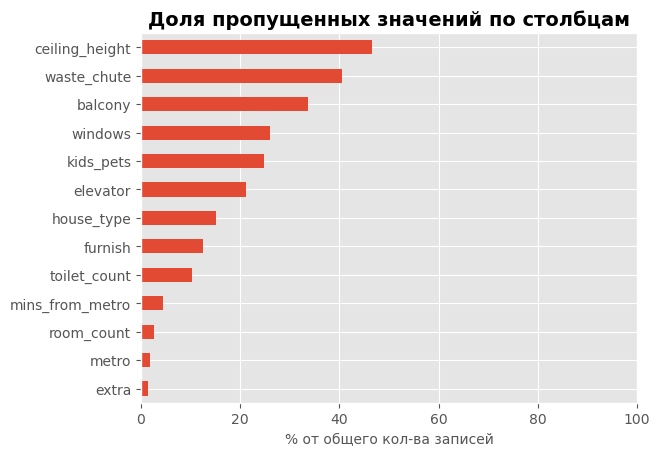

In [17]:
# Смотрим пропуски
missing_values = (df.isna().sum() / len(df) * 100).sort_values(ascending=True)
missing_values[missing_values > 0].plot(kind='barh')
plt.title('Доля пропущенных значений по столбцам', fontsize=14, fontweight='bold')
plt.xlabel('% от общего кол-ва записей', fontsize=10)
plt.xlim(0, 100);

In [18]:
# Меняем пропуски в признаке "туалеты" на 1, как наиболее вероятный
df['toilet_count'] = df['toilet_count'].fillna(1)

In [19]:
# Меняем пропуски в признаке "кол-во комнат" на 1, как наиболее вероятное
df['room_count'] = df['room_count'].fillna(1)

In [20]:
# Проставляем в пропуски в признаке "Ремонт" значение "Без ремонта", т.к. соответствующего чекбокса нет в Циане
df['furnish'] = df['furnish'].fillna('Без ремонта')

In [21]:
# Заполняем пропуски в признаке "высота потолков" медианным значением
df['ceiling_height'] = df['ceiling_height'].fillna(df['ceiling_height'].median())

In [22]:
# Предполагаем, что если в признаке "Мусоропровод" пропуск, значит мусоропровода нет
df['waste_chute'] = df['waste_chute'].fillna('Нет')

In [23]:
# Если балкон не указан, то его скорее всего нет
df['balcony'] = df['balcony'].fillna(0)

In [24]:
# В пропуски по признаку "Вид из окна" поставили наиболее нейтральное значение
df['windows'] = df['windows'].fillna('На улицу и двор')

In [25]:
# При заполнении карточки квартиры на Циан нет возможности четко указать "нельзя с детьми или животными" (нет такого чекбокса)
df['kids_pets'] = df['kids_pets'].fillna('Нет')

In [26]:
# По статистике, в 30% домов в Мск нет лифтов: https://www.perplexity.ai/search/v-kakoi-dole-domov-v-moskve-ne-CexcM.YkQDqGhmUfib0g1g
df['elevator'] = df['elevator'].fillna(0)

In [27]:
# Указываем значение моды для типа дома + по статистике, 40% домов в Мск панельные: https://realty.yandex.ru/journal/post/tipovye-panelki-samye-populyarnye-moskovskie-serii-ot-hrushchyova-do-nashih-dney/
# Дропаем нестандартные типы домов
df = df[df['house_type'] != 'Деревянный']
df = df[df['house_type'] != 'Щитовой']
df['house_type'] = df['house_type'].fillna('Панельный')

In [28]:
# Если метро не указано, скорее всего квартира находится слишком далеко от метро (вручную проверяли на примерах)
df['metro'] = df['metro'].fillna('Нет метро')

In [29]:
# Заполняем пропуски в "минуты от метро", заодно превращаем признак в близко-далеко
df['mins_from_metro'] = df['mins_from_metro'].fillna(999)
df['close_to_metro'] = df['mins_from_metro'].map(lambda x: True if x < 20 else False)
df = df.drop('mins_from_metro', axis=1)

In [30]:
# Кодируем данные в extra методом one-hot (попутно избавляясь от nan) и удаляем изначальный столбец
df = df.join(df['extra'].str.get_dummies(sep=', '))
df = df.rename(columns={'Мебель в комнатах':'furnished_rooms', 
                        'Мебель на кухне':'furnished_kitchen',
                        'Ванна':'bath', 
                        'Душевая кабина':'shower', 
                        'Стиральная машина':'wash_machine', 
                        'Кондиционер':'aircon', 
                        'Посудомоечная машина':'dishwasher', 
                        'Телевизор':'tv', 
                        'Холодильник':'fridge', 
                        'Интернет':'internet', 
                        'Телефон':'telephone'})
df = df.drop('extra', axis=1)

In [31]:
# Проверяем на отсутствие пропусков
df.isna().sum().unique()

array([0])

In [32]:
# Экспортируем датасет
df.to_csv('../data/data.csv', index=False)